In [2]:
import MeCab
import pandas as pd
import re
import itertools
import math
import numpy as np
from src.vectrizer import ContentVectorizer
from src.clustering import ClustarGenerator
from src.network_generater import NetworkGenerater

cv = ContentVectorizer()
cg = ClustarGenerator()
ng = NetworkGenerater()

# ユーザー辞書を設定
m_t = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -u data/fragrance_user_dic.dic')
wakati = MeCab.Tagger ("-Owakati -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -u data/fragrance_user_dic.dic")


# メタ付与する文章を読み込み
article_df = pd.read_table('data/perfume_sentence.tsv')

colname = ['surface', 'pos1', 'pos2', 'empty1', 'empty2', 'empty3', 'empty4', 'nomarization', 'category1', 'empty5', 'empty6', 'empty7', 'empty8', 'empty9', 'pos3', 'empty10', 'sign']

/usr/local/lib/python3.6/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [1]:
#!pip install ginza
#!pip install fastprogress japanize-matplotlib
#!find / | grep spacy | grep data
#!ln -s /usr/local/lib/python3.6/site-packages/ja_ginza /usr/local/lib/python3.6/site-packages/spacy/data/ja_ginza
#!pip install neologdn

     |████████████████████████████████| 9.9 MB 205 kB/s eta 0:00:01     |▉                               | 245 kB 710 kB/s eta 0:00:14     |████████████████████████████▌   | 8.8 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 51.5 MB 21 kB/s  eta 0:00:01    |████▉                           | 7.7 MB 2.1 MB/s eta 0:00:21     |█████                           | 7.9 MB 2.1 MB/s eta 0:00:21     |██████▊                         | 10.8 MB 1.3 MB/s eta 0:00:33     |███████▍                        | 12.0 MB 1.8 MB/s eta 0:00:23     |███████▌                        | 12.1 MB 1.8 MB/s eta 0:00:23     |███████▋                        | 12.2 MB 1.8 MB/s eta 0:00:23     |███████▉                        | 12.7 MB 1.8 MB/s eta 0:00:22     |████████▉                       | 14.1 MB 1.8 MB/s eta 0:00:22     |██████████████▎                 | 23.0 MB 1.5 MB/s eta 0:00:19     |████████████████████▌           | 33.0 MB 2.5 MB/s eta 0:00:08     |███████████████████████▌        | 37.8 MB 2.2 M

/usr/local/lib/python3.6/site-packages/spacy/cli/__pycache__/debug_data.cpython-36.pyc
/usr/local/lib/python3.6/site-packages/spacy/cli/debug_data.py
/usr/local/lib/python3.6/site-packages/spacy/data
/usr/local/lib/python3.6/site-packages/spacy/data/__init__.py
/usr/local/lib/python3.6/site-packages/spacy/data/__pycache__
/usr/local/lib/python3.6/site-packages/spacy/data/__pycache__/__init__.cpython-36.pyc


In [3]:
article_df

,article_id,title,description,feature_meta
0,S1,NaN,オゥパラディのローズは、精油のバラの香りが好きなら是非試していただきたいフレグランスです♪ダ...,NaN
1,S2,NaN,ベルガモットが持つアロマティックな柑橘帳の香りがお好みなら、シトロンの香水がおすすめ！爽やか...,NaN
2,S3,NaN,季節もシーンも選ばず、どこでも使いやすい香りとして大人気の香り「フルール」。その名の通り、程...,NaN
3,S4,NaN,「サボン」もフルールと同じく、日本人の嗅覚にぴったり合う非常に人気の香り。その名の通り入浴剤...,NaN
4,S5,NaN,甘酸っぱく可憐なイチゴの香りが楽しめる「フレーズ」は、付けているだけで幸せになれそうな大人か...,NaN
...,...,...,...,...
95,S96,NaN,女性なら誰しもが憧れるであろう、人気のクリスチャン・ディオール。その肩書にふさわしい、みずみ...,NaN
96,S97,NaN,スズランの香水といえば、まず最初に、Diorの「ディオリッシモ」が思い浮かびます。ディオリッ...,NaN
97,S98,NaN,miu miuの香水はローブルーや、ローロゼなど、スズランをメインとして香水が多いのですが、...,NaN
98,S99,NaN,ジョーマローンの「アンバー＆ラベンダー コロン」は、香水ファンにこそぜひ使っていただきたいエ...,NaN


In [4]:
# 学習済みベクトルを差し替える

#model_path = "model/awg_word2vec.model"
#cv.load_model(model_path)
#cv.ginza.vocab.vectors.shape

# 文章から抽出したワードのベクトルを作成する

以下のようなテーブルを作成し、`特徴語リスト`の単語をそれぞれベクトル化する。

|  記事文章  |  特徴語リスト  |
| ---- | ---- |
|  記事文章1  |  特徴語,特徴語,特徴語…  |
|  記事文章2  |  特徴語,特徴語,特徴語…  |
|  ...  |  ...  |

ベクトル化できなかった単語は`empty_w`リストに入れておく。使用する学習モデルの性能確認用。

In [52]:
# 辞書から特定のカテゴリーに属するワードを抽出する
feature = [] # 記事ごとに特徴語リストを格納
word_class = [] # 記事の文章から抽出した一意のワードを格納
wlstr_ = [] # 一時変数
empty_w = [] # ベクトル化できない単語を格納（ゼロベクトルのリスト）
insyou = []
for i, sentence in enumerate(article_df['description']):
    parsed_s = m_t.parse(sentence).replace('\t',',').split('\n')
    parsed_results = pd.Series(parsed_s).str.split(',').tolist()
    df_raw = pd.DataFrame(parsed_results, columns = colname)
    # 'category1'に「香り」か「印象」属性が登録されている単語をDataFarameに登録
    f_df = df_raw[(df_raw['category1'] == '香り') | (df_raw['category1'] =='印象')]
    # 単語と香りor印象属性を抽出する
    f_m = []
    attr_dic = {}
    for s,c in zip(f_df['surface'],f_df['category1']):
        doc,vector = cv.vectorize(s)
        if c == '印象':
            insyou.append(s)
        attr_dic = {'word':doc,'category':c}
        if vector.all():
            if str(doc) not in wlstr_:
                word_class.append(doc)
                wlstr_.append(str(doc))
            f_m.append(attr_dic)
        else:
            empty_w.append(doc)
    feature.append(f_m)
    
# 出力
print('ベクトル化できなかった単語:',empty_w)

ベクトル化できなかった単語: [マンダリン, パチョリ, ベルガモット, アロマティック, サボン, イチゴ, イチゴ, イチゴ, かき氷, キャンディ, イチゴ, マンダリン, ウッディ, マンダリン, シダー, ウッディ, サボン, ベルガモット, マンダリン, ナツメグ, ムスク, マンダリン, ベチバー, シダー, ヒヤシンス, フリージア, フルーティ, とろける, ヒヤシンス, フリージア, ピオニー, ライチ, ムスク, モテる, ピオニー, モテる, フリージア, ランバン, みずみずしい, 愛され, ムスク, スイートピー, モテる, 愛され, モテる, グルマン, サボン, まろやか, フルーティ, アロマオイル, みずみずしい, ピオニー, ピオニー, 月桂樹, ベルガモット, みずみずしい, ペアー, フリージア, みずみずしい, フリージア, パチョリ, ウッディ, ウッディ, ライチ, ウッディ, ウッディ, ウッディ, ウッディ, ウッディ, ムスク, ウッディ, ウッディ, ウッディ, ベチバー, ウッディ, ウッディ, ウッディ, フルーティ, ウッディ, ウッディ, ムスク, ウッディ, ムスク, ムスク, チュベローズ, マンダリン, 奥ゆかしい, イチゴ, ペアー, フルーティ, ピオニー, パチョリ, マンダリン, モテる, チュベローズ, パチョリ, グルマン, ハーバル, シダー, サボン, ベルガモット, ムスク, ベチバー, ムスク, ベルガモット, ムスク, ベルガモット, ムスク, ムスク, ベルガモット, ムスク, 月桂樹, ムスク, ムスク, ベルガモット, カルダモン, クローブ, ウッディ, チュベローズ, チュベローズ, ムスク, ウッディ, チュベローズ, チュベローズ, チュベローズ, チュベローズ, ベルガモット, ライチ, 柑橘類, ベルガモット, 弾ける, フリージア, ベルガモット, カルダモン, ハーバル, ムスク, 弾ける, ハーバル, パチュリ, ウッディ, ウッディ, パチュリ, フルーティ, チュベローズ, ベルガモット, ピオニー, ライチ, フリージア, ベルガモット, ライラック, ウッディ, かっこいい, ハーバル, ベルガモット, ウッディ, ウッディ, ハーバル, ムス

In [54]:
from collections import Counter
mycount=Counter(insyou)
print(mycount)

Counter({'爽やか': 38, 'フレッシュ': 25, 'セクシー': 20, '華やか': 19, '清潔': 16, '上品': 16, '優しい': 15, 'ほんのり': 15, 'シンプル': 10, 'エレガント': 9, 'ふんわり': 8, 'ナチュラル': 8, '柔らかい': 8, 'アクセント': 8, 'さっぱり': 7, '落ち着いた': 7, '可憐': 6, '苦味': 6, '気品': 6, '女性らしい': 6, 'ミステリアス': 6, 'リラックス': 5, 'モテる': 5, '高貴': 5, 'みずみずしい': 5, 'モダン': 5, '優雅': 4, '女の子らしい': 4, 'ハッピー': 4, '透明感': 4, 'フェミニン': 4, 'クール': 4, '安心': 4, '洗練された': 4, '重厚': 4, 'リフレッシュ': 3, 'ジューシー': 3, '贅沢': 3, 'しっとり': 3, '明るい': 3, '落ち着く': 3, '不思議': 3, 'こってり': 3, '弾ける': 3, '尖った': 2, 'リフレッシュしたい': 2, '大人っぽい': 2, '愛され': 2, '温かい': 2, '清らか': 2, '遊び心': 2, 'カジュアル': 2, '凛とした': 2, '軽い': 2, 'ロマンチック': 2, '気分転換': 2, '可愛い': 2, '大人かわいい': 1, 'ゆったり': 1, '奥行きのある': 1, 'とろける': 1, '懐かしい': 1, '上質': 1, '儚げな': 1, 'まろやか': 1, '知的': 1, '清々しい': 1, 'ディープ': 1, 'ラグジュアリー': 1, '奥ゆかしい': 1, 'ハンサム': 1, 'アクティブ': 1, '安らぎ': 1, 'エネルギッシュ': 1, 'かっこいい': 1, '深みのある': 1, '重い': 1, '引き締まった': 1, '開放感': 1, '深い': 1, '純粋': 1, '水': 1, '幸福': 1, '繊細': 1, '奥深い': 1, 'キリッとした': 1})


In [8]:
from gensim.models import word2vec
import neologdn

def wakati_system(text,wakati):
    text = neologdn.normalize(text)
    wakati.parse("").replace('\n','')
    wakati_text = wakati.parse(text).strip()
    return wakati_text

def remove_stopwords(words, stopwords):
    words = [word for word in words if word not in stopwords]
    return words

In [21]:
import requests
slothlib_path = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
slothlib_file = requests.get(slothlib_path)
stopword = slothlib_file.text.split()
my_stop_word = ["。","の",'♪','「','」','♥','♡','(','!',')','、','○','◎']
for word in my_stop_word:
    stopword.append(word)

In [38]:
descriptions = article_df['description'].values
wakati_list = []
for description in descriptions:
    res = wakati_system(description,wakati).split(" ")
    res = remove_stopwords(res,stopword)
    wakati_list.append(res)
#print(wakati_list)

In [23]:
model = word2vec.Word2Vec(wakati_list, size=100, workers=4, sg=1, min_count=5,window=10)

In [80]:
# 辞書ワードの抽出
fragrance_words = []
impression_words = []
with open("data/fragrance_user_dic.csv","r") as f:
    lines = f.readlines()
    for line in lines:
        if line.split(",")[11] == "香り":
            fragrance_words.append(line.split(",")[0])
        else:
            impression_words.append(line.split(",")[0])
mixture_words = fragrance_words + impression_words

In [87]:
def similar_word(mycount,model,request_words):
    for word,count in mycount.most_common(10):
        try:
            print(word)
            related_word = model.wv.similar_by_word(word,topn=200)
            count = 0
            for word, cosim in related_word:
                if count == 10:
                    print("")
                    break
                if word in request_words:
                    print(word, cosim)
                    count += 1
        except:
            print("$0 は、登録されていない印象です。".format(word))

In [88]:
# 印象ワードに近い香りワードの出力
similar_word(mycount,model,fragrance_words)

爽やか
スパイス 0.9993150234222412
フリージア 0.999311625957489
ピーチ 0.9992462396621704
石鹸 0.9991844892501831
ゼラニウム 0.9991744756698608
スパイシー 0.9991708993911743
マンダリン 0.9991616010665894
フラワー 0.9991604089736938
甘酸っぱい 0.9991499185562134
ベルガモット 0.9991439580917358

フレッシュ
オレンジ 0.9994064569473267
グレープフルーツ 0.9993948936462402
レモン 0.9993757009506226
柑橘系 0.9993715882301331
フラワー 0.9993340969085693
サンダルウッド 0.9993246793746948
マンダリン 0.999313473701477
フリージア 0.9992915987968445
ピオニー 0.9992839097976685
カシス 0.9992837905883789

セクシー
シトラス系 0.9993124008178711
オリエンタル 0.9992967247962952
サンダルウッド 0.9992915391921997
カシス 0.9992380142211914
パチョリ 0.9992326498031616
ピーチ 0.9992239475250244
ローズマリー 0.9992054104804993
チュベローズ 0.9991973638534546
ウッディ 0.9991865158081055
レザー 0.9991621971130371

華やか
ローズ 0.9993950724601746
チュベローズ 0.999343991279602
フラワー 0.9992700815200806
ジャスミン 0.9991891980171204
ピオニー 0.9991748929023743
サンダルウッド 0.999172568321228
フリージア 0.9991265535354614
ムスク 0.9991216063499451
甘酸っぱい 0.9991138577461243
オレンジ 0.9990898966789246

In [100]:
#similar_word(mycount,model,impression_words)

In [101]:
model.wv.similarity("ピーチ","石鹸")

0.9994473

In [97]:
def similar_word(mycount,model,request_words):
    for word,count in mycount.most_common(10):
        try:
            print(word)
            related_word = model.wv.similar_by_word(word,topn=200)
            count = 0
            sim_words = []
            for word, cosim in related_word:
                if count == 10:
                    print("")
                    break
                if word in request_words:
                    print(word, cosim)
                    sim_words.append(word)
                    count += 1
            
        except:
            print("$0 は、登録されていない印象です。".format(word))

In [98]:
similar_word(mycount,model,impression_words)

爽やか
リラックス 0.9992156028747559
ふんわり 0.9992066621780396
気品 0.9991748929023743
ほんのり 0.9991459846496582
高貴 0.9991415739059448
さっぱり 0.9991133213043213
みずみずしい 0.9991068840026855
ナチュラル 0.9991065263748169
ハッピー 0.9990983009338379
シンプル 0.9990724921226501

['リラックス', 'ふんわり', '気品', 'ほんのり', '高貴', 'さっぱり', 'みずみずしい', 'ナチュラル', 'ハッピー', 'シンプル']
フレッシュ
苦味 0.9994019865989685
みずみずしい 0.9992820024490356
さっぱり 0.9992793202400208
高貴 0.9992658495903015
シンプル 0.9992507100105286
リラックス 0.9992444515228271
アクセント 0.9992408752441406
ナチュラル 0.9992283582687378
ふんわり 0.9992273449897766
気品 0.999221682548523

['苦味', 'みずみずしい', 'さっぱり', '高貴', 'シンプル', 'リラックス', 'アクセント', 'ナチュラル', 'ふんわり', '気品']
セクシー
さっぱり 0.9993884563446045
シンプル 0.9993201494216919
女性らしい 0.9992594122886658
高貴 0.9992368817329407
落ち着いた 0.9992119073867798
可憐 0.9992107152938843
ふんわり 0.9991924166679382
ナチュラル 0.9991673231124878
リラックス 0.9991596341133118
気品 0.9991558790206909

['さっぱり', 'シンプル', '女性らしい', '高貴', '落ち着いた', '可憐', 'ふんわり', 'ナチュラル', 'リラックス', '気品']
華やか
高貴 0.9990975260734558


# 特徴語の類似度テーブルを作成する

|  特徴語A  |  特徴語B  |  類似度(スコア)  |
| ---- | ---- | ---- |
|  特徴語  |  特徴語  |  0.356119  |
|  特徴語  |  特徴語  |  0.464299  |
|  ...  |  ...  |  ...  |

特徴語同士がどれくらい似ているか比較します。1に近いほど2つの特徴語が似ていることになります。  
ただし、学習モデルに登録されていないワードは抜き出せません。  
例：「ダマスクローズ」というワードは学習モデルに存在しないため、「ダマスク」と「ローズ」それぞれのベクトルの平均値が「ダマスクローズ」のベクトルとして出力されます。  
　　「ダマスク」というワードが存在しない場合は「ローズ」のベクトルが出力されます。

In [40]:
# 特徴語の組み合わせを全パターン作成する
meta_parts_pairs = []
for pair in itertools.combinations(word_class, 2):
    meta_parts_pairs.append(pair)

# 特徴語の類似度（ベクトル同士の類似度）を計算する
score = []
for doc1,doc2 in meta_parts_pairs:
    score.append(doc1.similarity(doc2))
    
# 上記の結果をテーブルに格納
target_df = pd.DataFrame(meta_parts_pairs)
target_df['2']=score

# 出力
target_df

,0,1,2
0,(ローズ),"(ダマスク, ローズ)",1.000000
1,(ローズ),(優雅),0.356119
2,(ローズ),(ふんわり),0.352181
3,(ローズ),(レモン),0.464299
4,(ローズ),"(尖っ, た)",0.321487
...,...,...,...
10291,(幸福),(奥深い),0.187721
10292,(幸福),"(キリッ, と, し, た)",0.150995
10293,(繊細),(奥深い),0.492646
10294,(繊細),"(キリッ, と, し, た)",0.334388


In [10]:
# target_df から 1.0 つまり同じ言葉になっているものを削除（ベクトル化が不十分）
drop_index_list = list(target_df[target_df['2'] >= 1.0].index)
target_df.drop(index = target_df.index[drop_index_list],inplace=True)
# 確認用 drop_index_list には、index 833 が入っていた
target_df[830:840]

,0,1,2
831,"(尖っ, た)","(フルーティ, フローラル)",0.195903
832,"(尖っ, た)",(重い),0.364623
834,"(尖っ, た)",(開放感),0.226223
835,"(尖っ, た)","(青, りんご)",0.266217
836,"(尖っ, た)",(深い),0.350756
837,"(尖っ, た)",(純粋),0.313154
838,"(尖っ, た)",(水),0.344411
839,"(尖っ, た)",(幸福),0.154951
840,"(尖っ, た)",(繊細),0.300774
841,"(尖っ, た)",(奥深い),0.261785


# クラスタリング
k-meansで特徴語をクラスタリングします。  
参考：[k-means法を理解する](https://qiita.com/g-k/items/0d5d22a12a4507ecbf11)

- `n_cluster`: クラスタ数を設定できます。  
- `cluster_result`: {クラスタID:特徴語リスト}な辞書です。

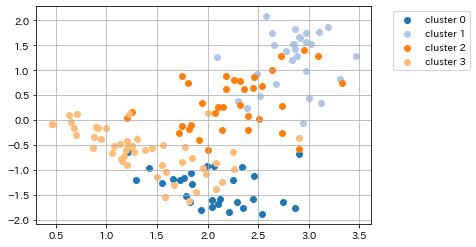

defaultdict(<class 'list'>, {2: [ローズ, ダマスクローズ, ふんわり, 生花, ジャスミン, 花, 石鹸, フレッシュ, サンダルウッド, 金木犀, オレンジ, ベリー, 桜, アンバー, フローラル系, ピーチ, シトラス, ホワイトフローラル, ミント, シャンプー, 白い花, セージ, ソルト, アロマ, オレンジブロッサム, フラワー, 桃, シトラス系, ゼラニウム, ピンクペッパー, オリエンタル, ミルキー, ローズマリー, アプリコット, フルーティフローラル], 0: [優雅, 爽やか, 可憐, 華やか, 気品, アクセント, エレガント, 上品, セクシー, 高貴, 上質, 透明感, 清らか, フェミニン, 遊び心, カジュアル, ミステリアス, 知的, エキゾチック, 清々しい, ラグジュアリー, 重厚, ハンサム, 安らぎ, ロマンチック, エネルギッシュ, モダン, 幸福, 繊細], 1: [レモン, 柑橘, 苦味, バニラ, ほんのり, シロップ, ジャム, グレープフルーツ, ジューシー, 柑橘系, スパイス, 甘い, ビターオレンジ, スパイシー, 甘酸っぱい, 紅茶, 洋梨, バジル, カシス, マンゴー, ラズベリー, アーモンド, フルーツ, ムース, イチジク, こってり, シナモン, ココナッツ, ジンジャー], 3: [尖った, ナチュラル, 優しい, 柔らかい, 清潔, 大人かわいい, リフレッシュ, ゆったり, 女性らしい, リフレッシュしたい, 奥行きのある, 大人っぽい, リラックス, 女の子らしい, ホワイトムスク, 懐かしい, ハッピー, 贅沢, 儚げな, しっとり, 温かい, さっぱり, シンプル, 明るい, 落ち着いた, アールグレイ, クール, 安心, 凛とした, レザー, シダーウッド, 落ち着く, ディープ, 洗練された, 不思議, アクティブ, 軽い, ラン, 気分転換, 深みのある, トンカビーン, 可愛い, 重い, 引き締まった, 開放感, 青りんご, 深い, 純粋, 水, 奥深い, キリッとした]})


In [11]:
vectorlist = np.array([w.vector for w in word_class])

# クラスタ数の設定
n_cluster = 4

cluster_result = cg.generate(title_list=word_class, 
            vector_list=vectorlist, 
            vector_size=100, 
            n_cluster = n_cluster)

print(cluster_result)

# クラスタごとのネットワークを作成
- `cluster_result_dict`: {クラスタID:特徴語同士の距離テーブル}な辞書を作成します。グラフ構造を作成するために使います。
- `cluster_df['2']>0.5`でスコアのしきい値を設定します。デフォルトでは0.5以下のスコアは表示されません。

In [12]:
cluster_word = cluster_result[0]

cluster_result_dict = {}
for class_id , cluster_word in cluster_result.items():
    meta_parts_pairs = []
    for pair in itertools.combinations(cluster_word, 2):
        meta_parts_pairs.append(pair)

    score = []
    for doc1,doc2 in meta_parts_pairs:
        score.append(round(doc1.similarity(doc2),3))

    cluster_df = pd.DataFrame(meta_parts_pairs)
    cluster_df['2']=score

    cluster_result_dict[class_id]=cluster_df[cluster_df['2']>0.5].sort_values('2',ascending=False)

# ネットワーク可視化
クラスタごとに特徴語のネットワークを作成します。

Cluster ID:  2


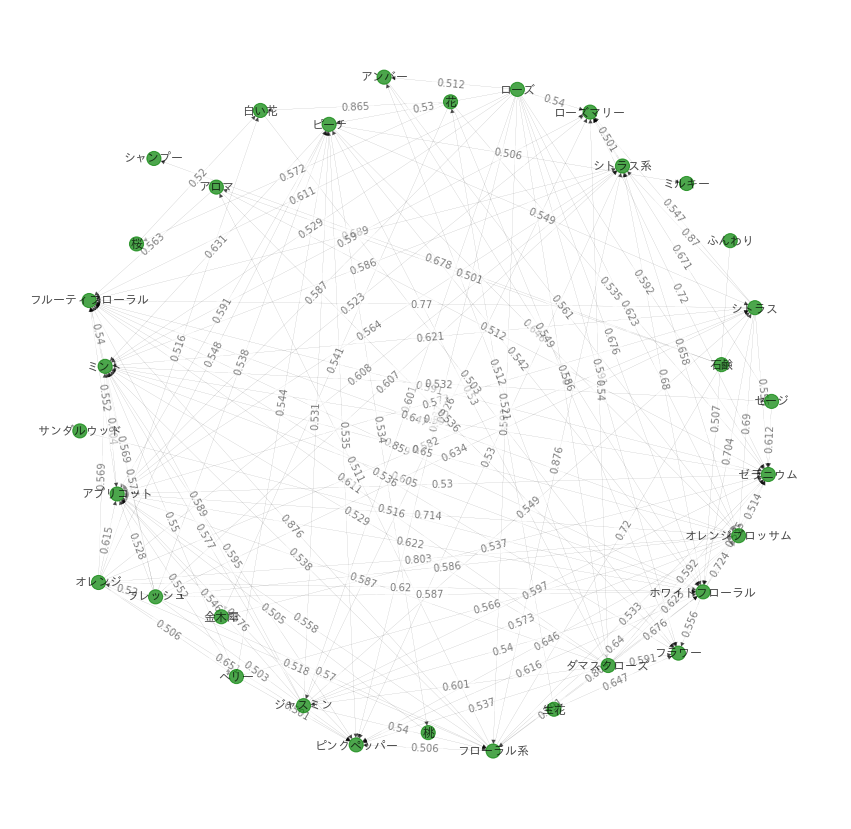

Cluster ID:  0


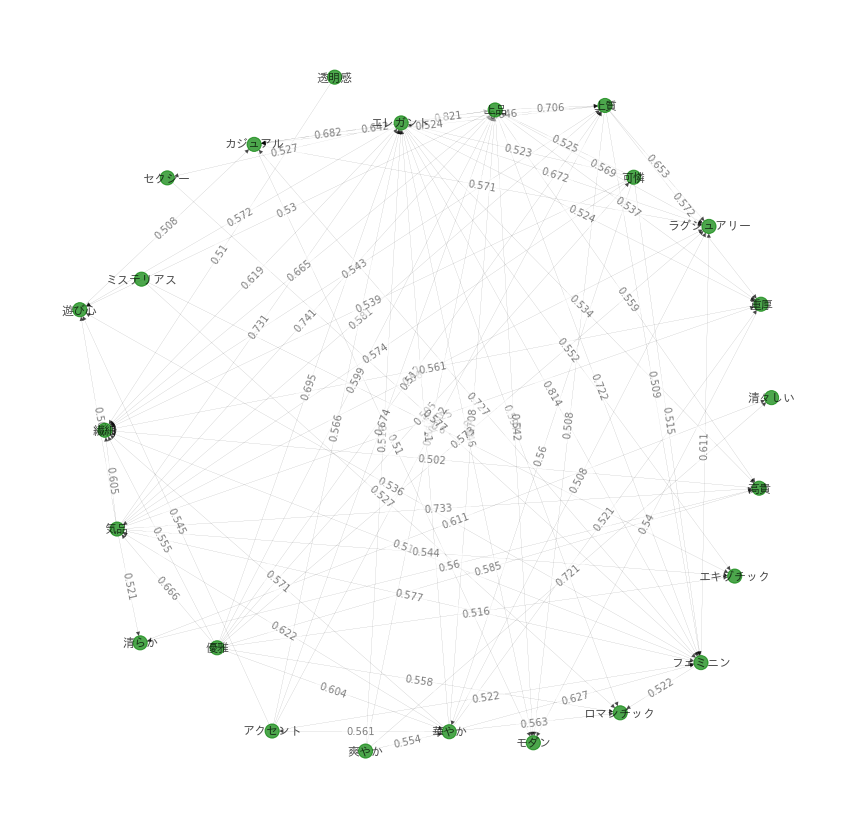

Cluster ID:  1


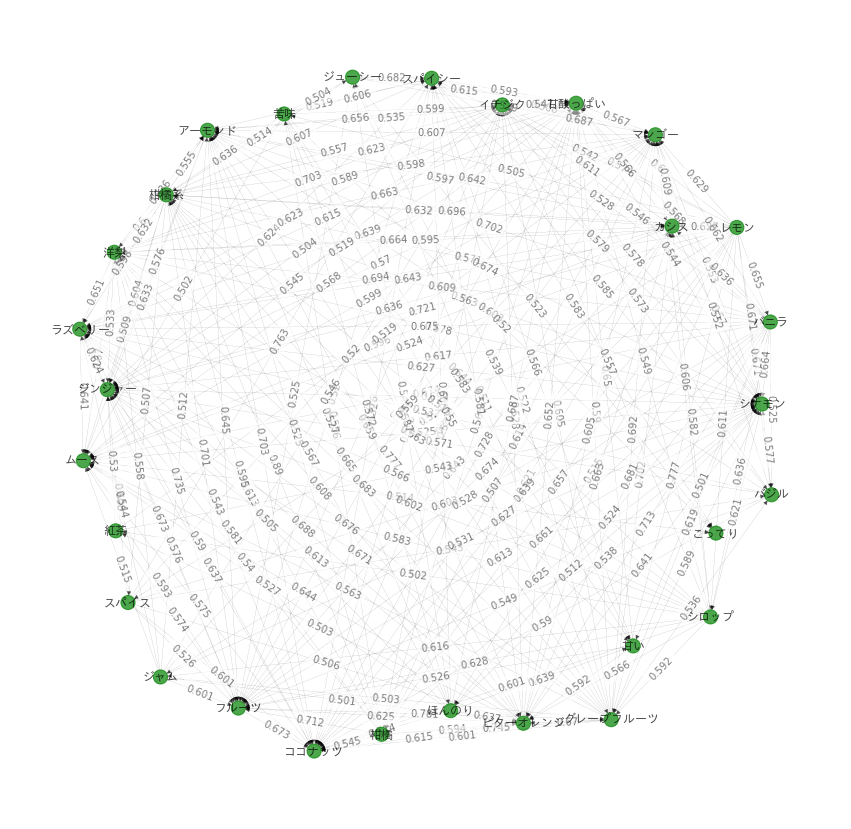

Cluster ID:  3


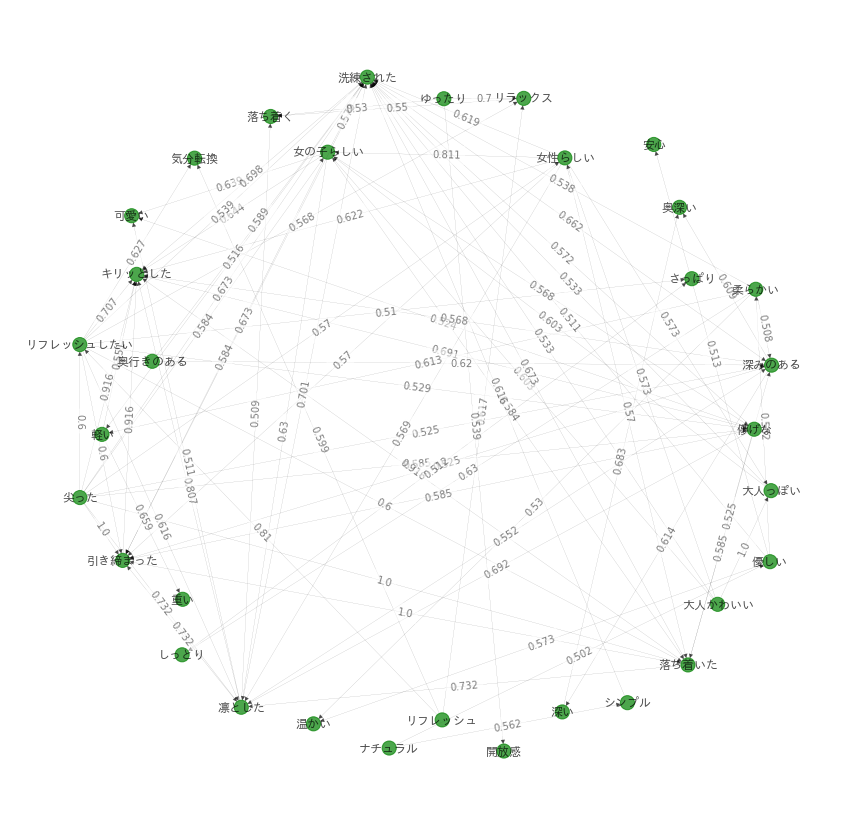

In [13]:
for clusterid, cluster in cluster_result_dict.items():
    print('Cluster ID: ',clusterid)
    ng.network(cluster.values.tolist(), 200, 0.005)